# What is CNN?

CNN, or Convolutional Neural Network, is a type of neural network particularly suited for handling data structured in a 2D matrix format, such as images. These networks excel in tasks related to image detection and classification, making them essential in various visual recognition applications.

# Library Import

In [19]:
from fastai.vision.all import *
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from fastai.vision.all import DataBlock, ImageBlock, CategoryBlock, RandomSplitter, get_image_files, Resize, aug_transforms, cnn_learner, resnet18, accuracy, parent_label, Normalize, imagenet_stats, Path

# Setting up path for training data

In [2]:
x  = '/kaggle/input/intel-image-classification/seg_train'
path = Path(x)
path.ls()

(#1) [Path('/kaggle/input/intel-image-classification/seg_train/seg_train')]

# Data Loading for Training

Key Points to Remember:

* Determine the validation percentage (e.g., 0.2 for 20%).
* Specify the path for the training data.
* Set the criteria for data augmentation (optional).
* Choose the image size (224 in your case).
* Optionally, include test data.

In [3]:
# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=40),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)

# Create the DataLoaders
dls = dblock.dataloaders(path)

# Print to verify DataLoaders creation
print(dls)

# Data Explorations

Our image dataset consists of .jpg files organized into two separate folders. Each folder is named after the model of the images it contains. To load these images and assign labels based on the folder names, we utilize the DataBlock() function.

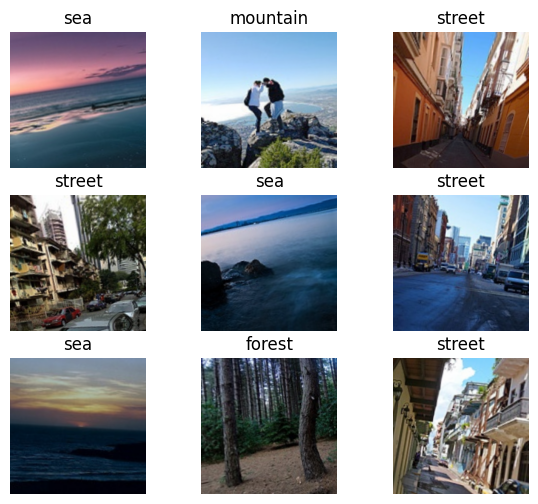

In [4]:
dls.show_batch(nrows = 3, figsize = (7,6))

# Print Classes present in the data

In [5]:
# Print a summary of the DataLoaders
print(f"Train: {len(dls.train_ds)} items")
print(f"Valid: {len(dls.valid_ds)} items")

Train: 11228 items
Valid: 2806 items


In [6]:
# Print class labels
print(f"Classes: {dls.vocab}")

# Print number of classes
print(f"Number of classes: {len(dls.vocab)}")

# Print the number of categories (same as number of classes)
print(f"Number of categories: {dls.c}")

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of classes: 6
Number of categories: 6


# Create The Model

We now employ a pre-trained ResNet18 Convolutional Neural Network model, leveraging transfer learning to adjust only the last layer's weights. The rationale behind transfer learning is that it allows us to start with an established neural network designed for image recognition and modify it slightly to suit our specific needs. This approach is beneficial because training a decent neural network from scratch requires around 300,000 image samples, and achieving excellent performance necessitates at least a million images.

Given that our training set contains about 2,500 images, training a neural network from scratch would be insufficient. Instead, we utilize the create_cnn() function to load a pre-trained ResNet18 model, which has been trained on approximately a million images from the ImageNet database. This method enables us to capitalize on the robustness of the pre-trained model and achieve satisfactory results with a limited dataset.

In [7]:
learn = cnn_learner(dls, resnet18, metrics=[accuracy], model_dir=Path('./models'), path=Path("."))

/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


# Finding LR

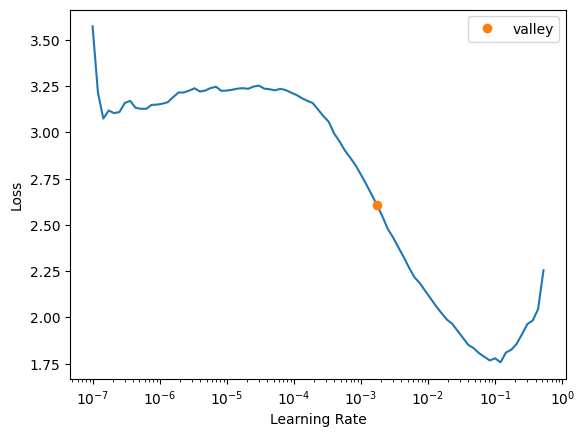

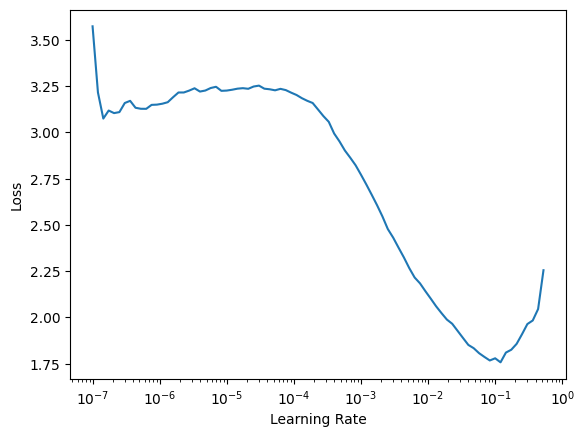

In [8]:
# Find the optimal learning rate
learn.lr_find()

# Plot the learning rate finder results with suggestions
learn.recorder.plot_lr_find()

# Train Model

In [9]:
# Define learning rates
lr1 = 1e-3
lr2 = 1e-2

# Train the model
learn.fit_one_cycle(40, slice(lr1, lr2))

epoch,train_loss,valid_loss,accuracy,time
0,0.547008,0.297587,0.901996,00:38
1,0.403446,0.265574,0.909836,00:33
2,0.335613,0.236150,0.918033,00:33
3,0.309309,0.305524,0.892374,00:33
4,0.311251,0.235366,0.924091,00:33
5,0.284465,0.224613,0.924448,00:33
6,0.305417,0.282827,0.915895,00:33
7,0.284714,0.218851,0.927655,00:33
8,0.264660,0.258418,0.910549,00:33
9,0.244022,0.230874,0.924804,00:33


In [11]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.103902,0.218498,0.935139,00:45
1,0.138773,0.245816,0.930150,00:44
2,0.201291,0.236937,0.929793,00:44
3,0.211981,0.340403,0.900214,00:44
4,0.211951,0.296094,0.900927,00:44
5,0.194784,0.294453,0.904847,00:44
6,0.187093,0.263305,0.914469,00:44
7,0.183455,0.241924,0.926230,00:44
8,0.145394,0.250590,0.916964,00:44
9,0.130482,0.264975,0.916607,00:44


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

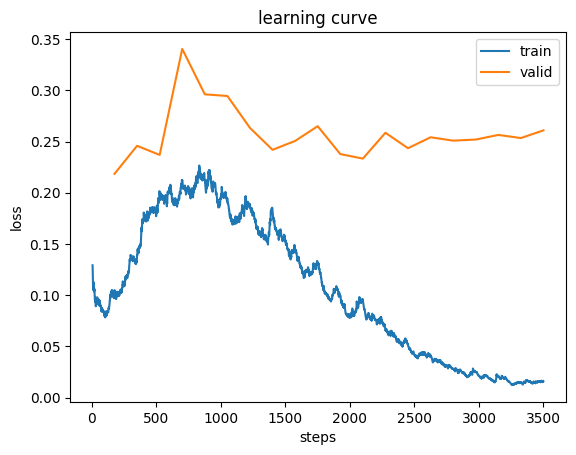

In [13]:
learn.recorder.plot_loss()

# Interpret the Result
A confusion matrix is a tool for validating model performance. It displays the number of correct and incorrect predictions for each class. The diagonal values represent correct predictions, indicating the model's accuracy for each category. Off-diagonal values show errors, highlighting where the model misclassified instances. For example, in a cat-dog classifier, the diagonal shows correct identifications, while off-diagonal entries reveal cats predicted as dogs or vice versa. Analyzing these errors helps identify model weaknesses and areas for improvement.

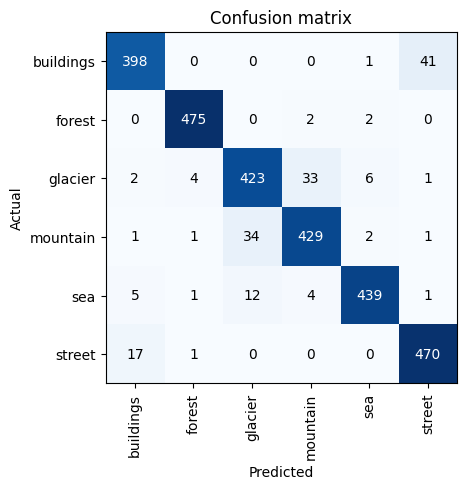

In [15]:
from fastai.vision.all import ClassificationInterpretation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

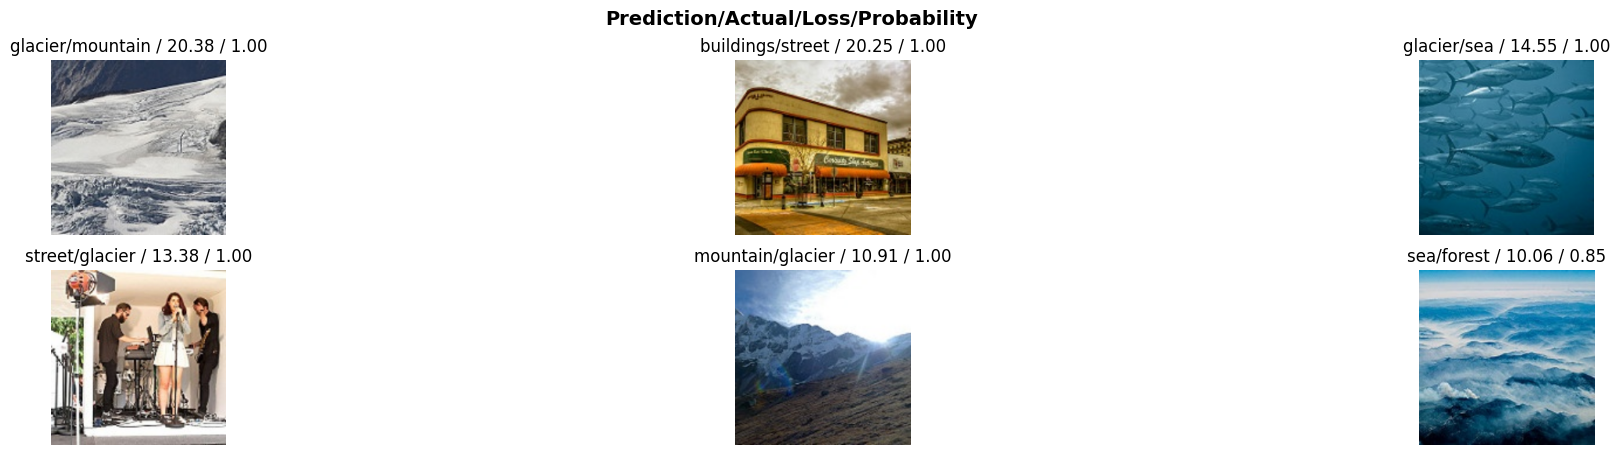

In [16]:
interp.plot_top_losses(6,figsize = (25,5))

# Prediction Using Trained Model

In [20]:
img = PILImage.create('/kaggle/input/intel-image-classification/seg_test/seg_test/glacier/21982.jpg')
print(learn.predict(img)[0])

glacier


# Save and Load Model

In [21]:
img = PILImage.create('/kaggle/input/intel-image-classification/seg_test/seg_test/glacier/21982.jpg')
print(learn.predict(img)[0])

glacier


In [23]:
learn.export("/kaggle/working/export.pkl")

In [25]:
learn.model_dir = "/kaggle/working"
learn.save("stage-1")

# Manually construct the path
model_path = Path(learn.model_dir) / "stage-1.pth"
print(f"Model weights saved to {model_path}")

Model weights saved to /kaggle/working/stage-1.pth
